In [38]:
from hdbcli import dbapi
import pandas as pd
import nltk as nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.cistem import Cistem
from nltk.stem import WordNetLemmatizer
from enum import Enum

In [2]:
connection = dbapi.connect('34.255.100.176', 39015, 'SYSTEM', 'Glorp2018!')
connection.isconnected()

True

In [3]:
cursor = connection.cursor()

# Teil 2

In [4]:
cmpl_data = pd.read_csv('./_TA_CDESCRIND__201911271735.csv')
t3n_data = pd.read_csv('./_TA_T3NTEXTIND__201912031756.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
t3n_data.head()

## Aufgabe 1 - Nouns per Document

### #Nouns per Document (Optional)

In [ ]:
t3n_nouns = t3n_data[t3n_data['TA_TYPE']=="noun"]
nouns_per_doc = t3n_nouns["ID"].value_counts()
ax = sns.distplot(nouns_per_doc)
ax.set(xlabel='#nouns per document')
ax.set_title('Nouns per document')
fig = ax.get_figure()

### Using Pandas

In [ ]:
cmpl_nouns = cmpl_data[cmpl_data['TA_TYPE']=="noun"]
cmpl_nouns.groupby('CMPLID')['TA_TOKEN'].value_counts()

def get_tokencount_per_document(doc_id, df):
    cmpl_nouns = df[df['TA_TYPE']=="noun"]
    cmpl_id = cmpl_nouns[cmpl_nouns['CMPLID'] == doc_id]
    return cmpl_id['TA_TOKEN'].value_counts()

### Using SQL-View

In [ ]:
# drop SQL-View
sql_drop_view = 'drop view COUNT_NOUNS'
cursor.execute(sql_drop_view)

In [ ]:
# nouns per document
sql = 'create view COUNT_NOUNS as select ID, TA_TOKEN, count(*) as COUNT from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID, TA_TOKEN'
cursor.execute(sql)

In [ ]:
cursor.execute('select * from COUNT_NOUNS')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.head(20)

## Aufgabe 2 Pandas Implementation 

### Size of Lexica before cleanup

In [ ]:
cmpl_lexica_size = cmpl_data['TA_TOKEN'].nunique()
t3n_lexica_size = t3n_data['TA_TOKEN'].nunique()
cmpl_normalized_lexica_size = cmpl_data['TA_NORMALIZED'].nunique()
t3n_normalized_lexica_size = t3n_data['TA_NORMALIZED'].nunique()

### Size of Lexica without punctuation and stopwords

In [5]:
def remove_unneeded_token_types(data):
    TA_TYPES_TO_REMOVE = set({'punctuation', 'number'})
    return data[~data['TA_TYPE'].isin(TA_TYPES_TO_REMOVE)]

def remove_stopwords(data, language):
    #nltk.download(language)
    stopword_set = set(stopwords.words(language))
    data['TA_TOKEN_LOW'] = data['TA_TOKEN'].map(lambda row: str(row).lower())
    return data[~data['TA_TOKEN_LOW'].isin(stopword_set)]

def remove_unique_tokens(data):
    return data.groupby('TA_TOKEN').filter(lambda x: len(x) > 1)

In [6]:
cmpl_data_cleaned = remove_unneeded_token_types(cmpl_data)
print("size of cmpl lexica after punctuation and number removal: " + str(cmpl_data_cleaned['TA_TOKEN'].nunique()))
cmpl_data_cleaned = remove_stopwords(cmpl_data_cleaned, 'english')
print("size of cmpl lexica after stopword removal: " + str(cmpl_data_cleaned['TA_TOKEN'].nunique()))
cmpl_data_cleaned = remove_unique_tokens(cmpl_data_cleaned)
print("size of cmpl lexica after removing unique words: " + str(cmpl_data_cleaned['TA_TOKEN'].nunique()))

size of cmpl lexica after punctuation and number removal: 63445


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


size of cmpl lexica after stopword removal: 63293
size of cmpl lexica after removing unique words: 35902


In [7]:
t3n_data_cleaned = remove_unneeded_token_types(t3n_data)
print("size of t3n lexica after punctuation and number removal: " + str(t3n_data_cleaned['TA_TOKEN'].nunique()))
t3n_data_cleaned = remove_stopwords(t3n_data_cleaned, 'german')
print("removing german stopwords. #Tokens left: " + str(t3n_data_cleaned['TA_TOKEN'].nunique()))
t3n_data_cleaned = remove_unique_tokens(t3n_data_cleaned)
print("removing unique tokens. #Tokens left: " + str(t3n_data_cleaned['TA_TOKEN'].nunique()))

size of t3n lexica after punctuation and number removal: 37567


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


removing german stopwords. #Tokens left: 37153
removing unique tokens. #Tokens left: 17606


### Size of Lexica after Stemming  / Lemmatizing

In [8]:
stemmer = Cistem() # German language stemmer
t3n_data_cleaned['TA_STEMMED'] = t3n_data_cleaned['TA_NORMALIZED'].map(lambda token: stemmer.stem(str(token)))
print("t3n lexica size before stemming: " + str(t3n_data_cleaned['TA_TOKEN'].nunique()))
print("t3n lexica size after stemming: " + str(t3n_data_cleaned['TA_STEMMED'].nunique())) 

t3n lexica size before stemming: 17606
t3n lexica size after stemming: 11166


In [9]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
cmpl_data_cleaned['TA_STEMMED'] = cmpl_data_cleaned['TA_NORMALIZED'].map(lambda token: lemmatizer.lemmatize(str(token)))
print("cmpl lexica size before stemming: " + str(cmpl_data_cleaned['TA_TOKEN'].nunique()))
print("cmpl lexica size after stemming: " + str(cmpl_data_cleaned['TA_STEMMED'].nunique())) 

[nltk_data] Downloading package wordnet to /Users/tobi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


cmpl lexica size before stemming: 35902
cmpl lexica size after stemming: 33056


### Mean Document / Sentence length

In [ ]:
mean_cmpl_doc_length = cmpl_data["CMPLID"].value_counts().mean()
mean_cmpl_sentence_length = cmpl_data.groupby("CMPLID")["TA_SENTENCE"].value_counts().mean()
print("mean cmpl doc length: " + str(mean_cmpl_doc_length))
print("mean cmpl sentence length: " + str(mean_cmpl_sentence_length))

In [ ]:
mean_t3n_doc_length = t3n_data["ID"].value_counts().mean()
mean_t3n_sentence_length = t3n_data.groupby("ID")["TA_SENTENCE"].value_counts().mean()
print("mean t3n doc length: " + str(mean_t3n_doc_length))
print("mean t3n sentence length: " + str(mean_t3n_sentence_length))

## Aufgabe 3

In [27]:
t3n_data_cleaned['FREQUENCY'] = t3n_data_cleaned['TA_TOKEN'].map(t3n_data_cleaned['TA_TOKEN'].value_counts())

In [39]:
t3n_data_cleaned.head()

,ID,TA_RULE,TA_COUNTER,TA_TOKEN,TA_LANGUAGE,TA_TYPE,TA_TYPE_EXPANDED,TA_NORMALIZED,TA_STEM,TA_PARAGRAPH,TA_SENTENCE,TA_CREATED_AT,TA_OFFSET,TA_PARENT,TA_TOKEN_LOW,TA_STEMMED,FREQUENCY
64532,eef9dbd4-5068-4a58-8d4a-b16324d2eab2,LXP,1,Wer,de,pronoun,NaN,wer,NaN,1,1,2019-11-29 22:51:51,0,NaN,wer,wer,379
64534,0cdf66f3-d716-4a4a-a1fc-b8809bf07c86,LXP,1,Neben,de,preposition,NaN,neben,NaN,1,1,2019-11-29 22:51:51,0,NaN,neben,neb,200
64537,bd546cf2-bbbe-4b5b-8674-590975935156,LXP,1,Cyber,de,noun,NaN,cyber,NaN,1,1,2019-11-29 22:51:51,0,NaN,cyber,cyber,24
64539,6dc301e3-1a07-44d1-b8c0-c46656884629,LXP,1,Joyn,de,noun,NaN,joyn,NaN,1,1,2019-11-29 22:51:51,0,NaN,joyn,joy,4
64540,480af0e8-de34-4895-90df-337c38a60815,LXP,1,Alexa,de,noun,NaN,alexa,NaN,1,1,2019-11-29 22:51:51,0,NaN,alexa,alexa,245


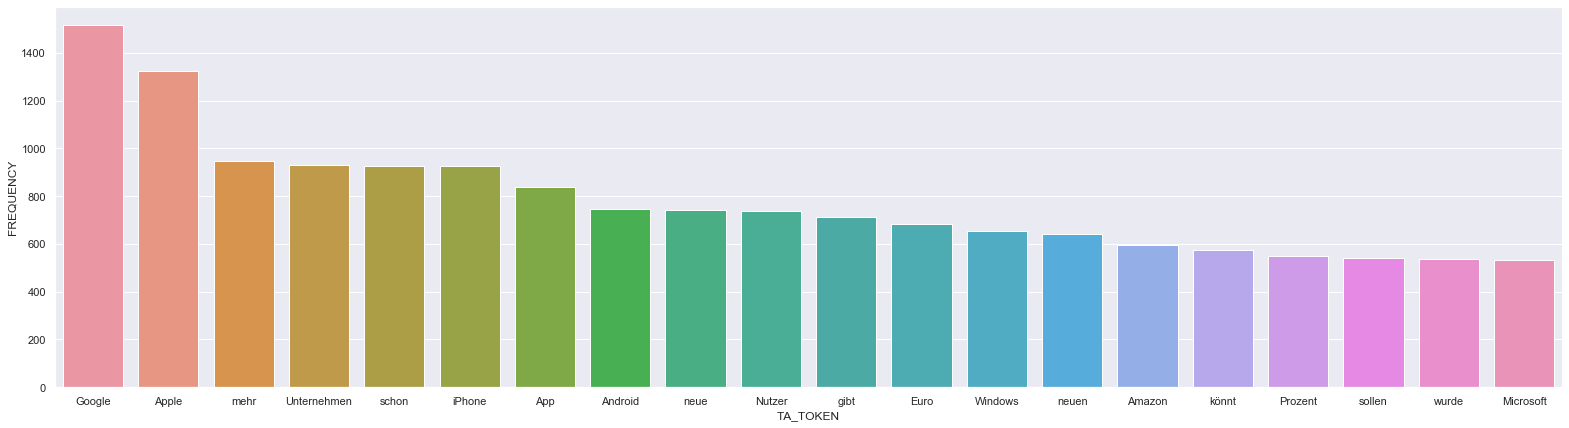

In [36]:
# frequent words
sns.set(rc={'figure.figsize':(27,7)})
most_occuring_tokens = t3n_data_cleaned.drop_duplicates(subset='TA_TOKEN').nlargest(20, 'FREQUENCY')
sns.barplot(x="TA_TOKEN", y="FREQUENCY", data=most_occuring_tokens)

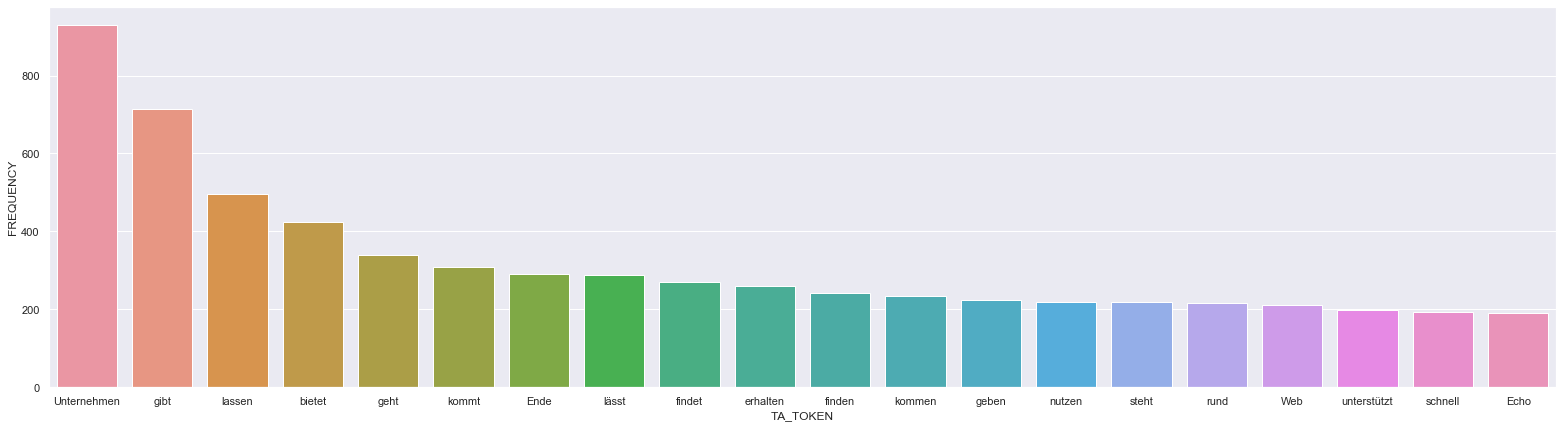

In [42]:
# frequent verbs
sns.set(rc={'figure.figsize':(27,7)})
most_occuring_tokens = t3n_data_cleaned[t3n_data_cleaned['TA_TYPE'] == 'verb'].drop_duplicates(subset='TA_TOKEN').nlargest(20, 'FREQUENCY')
sns.barplot(x="TA_TOKEN", y="FREQUENCY", data=most_occuring_tokens)

# Tokenization (obsolete)

In [ ]:
nltk.download('punkt')

In [ ]:
t3n_data_tokenized = t3n_data
t3n_data_tokenized['text'] = t3n_data_tokenized.apply(lambda row: nltk.word_tokenize(str(row['text'])), axis=1)
t3n_data_tokenized['teaser'] = t3n_data_tokenized.apply(lambda row: nltk.word_tokenize(str(row['teaser'])), axis=1)
t3n_data_tokenized['heading'] = t3n_data_tokenized.apply(lambda row: nltk.word_tokenize(str(row['heading'])), axis=1)

In [ ]:
for index, row in t3n_data.iterrows():
    print(row['heading'])